# Construction de Psi

## Librairies

In [1]:
from kymatio.numpy import Scattering1D
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
from maad.features import tfsd
from maad.sound import spectrogram
from maad.util import plot2d, power2dB
import os
import h5py

## Pour JobLib

In [2]:
from joblib import Memory
import time

cachedir = './joblib_cache'
memory = Memory(cachedir)

## Construction

### Outils

In [3]:
# Function to get the sound with filename
def getSound(filename, duration):
    fe, sound = wavfile.read(filename)
    nbSamples = round(fe * duration)
    sound = sound[0:nbSamples]
    return sound, fe


# Function to get the sound with position
def getSoundAtPosition(root, position, duration):
    return getSound(getFilenameAtPosition(root, position), duration)


# Function to get the filename with position
def getFilenameAtPosition(root, position):
    for root, dirnames, filenames in os.walk(root):
        f = filenames[position]
        filename = os.path.join(root, f)
        return filename


# Function to get the position with filename
def getPositionOfFilename(root, filename):
    for root, dirnames, filenames in os.walk(root):
        k = 0
        for f in filenames:
            if f == filename:
                return k
            else:
                k += 1


# Display the spectrogram of a sound
def displaySpectrogram(sound, fe, title, ax):
    
    spec, tn, fn, ext = spectrogram(sound, fe)   
    spec_dB = power2dB(spec)

    fig_kwargs = {'vmax': spec_dB.max(),'vmin':-70,'extent':ext,'title':title,'xlabel':'Time [sec]','ylabel':'Frequency [Hz]'}

    plot2d(spec_dB,**fig_kwargs, ax = ax, colorbar = False, now = False)


# Get the date associated to a filename
def getDateFromFilename(filename, with_root = False, root = "", with_year = True):

    if with_root:
        filename = filename[len(root) + 1:]

    _, day, hour = filename.split('_')

    if with_year:
        day = "{}/{}/{}".format(day[6:8], day[4:6], day[0:4])
    else:
        day = "{}/{}".format(day[6:8], day[4:6])

    hour = "{}:{}".format(hour[0:2], hour[2:4])
    date = "{} {}".format(day, hour)

    return date


# Return all the dates
def getAllDates(root, with_year = True):
    dates = []
    for root, dirnames, filenames in os.walk(root):
        for f in filenames:
            dates.append(getDateFromFilename(f, with_year = with_year))
    return dates

### Pertinence

In [4]:
def compute_pertinence(sound, fe):
    Spec, tn, fn, _ = spectrogram(sound, fe)
    q = tfsd(Spec, fn, tn)
    return np.sqrt(q)

### Descripteur

In [5]:
def compute_descriptor(sound, J, Q):
    
    T = sound.shape[-1]

    scattering = Scattering1D(J, T, Q)

    scalogram = scattering(sound / np.max(np.abs(sound)))

    order2 = np.where(scattering.meta()['order'] == 2)

    descriptor = scalogram[order2]
    descriptor = np.mean(descriptor, axis=1)
    descriptor = descriptor / np.linalg.norm(descriptor)

    return descriptor

### PSI

In [6]:
# Valeur maximale de nbSounds : 432
def compute_PSI(root, J, Q, duration, nbSounds, verbose = True):
    
    psi = [0] * nbSounds
    
    k = 0
    progress = -1
    for root, dirnames, filenames in os.walk(root):
        for f in filenames:
            
            if k >= nbSounds:
                break
                
            percentage = round(k/nbSounds * 100)
            if (percentage % 10) == 0 and percentage > progress and verbose:
                progress = percentage
                print(percentage, "%")
                
            filename = os.path.join(root, f)
            
            sound, fe = getSound(filename, duration)
            q = compute_pertinence(sound, fe)
            d = compute_descriptor(sound, J, Q)
            psi[k] = q*d
            k += 1
    if verbose:    
        print("DONE")
    
    return np.array(psi)



def getpsi(verbose = True):

    persisted_psi = h5py.File("./persisted_data/psi.hdf5", "a") # append mode : create file if it doesnt exist

    if 'psi_1' in persisted_psi:
        if verbose:
            print("loading psi from persisted file")
        psi = persisted_psi['psi_1'][:]
    else:
        if verbose:
            print("creating psi and persisting it to a file")
        J, Q = 8, 3
        psi = compute_PSI('./SoundDatabase', J, Q, 5, 432, verbose = verbose) 
        persisted_psi.create_dataset('psi_1', data=psi)

    persisted_psi.close()

    return psi

## Mesure de similarité

In [7]:
def similarity(position1, position2, psi):
    sound1 = psi[position1]
    sound2 = psi[position2]
    cos = np.dot(sound1, sound2) / (np.linalg.norm(sound1) * np.linalg.norm(sound2))
    return cos

In [8]:
def similarity_all(psi):
    nbSounds = psi.shape[0]
    similarities = np.zeros((nbSounds, nbSounds))
    for j in range(nbSounds):
        for i in range(nbSounds):
            similarities[i, j] = similarity(i, j, psi)
    return similarities

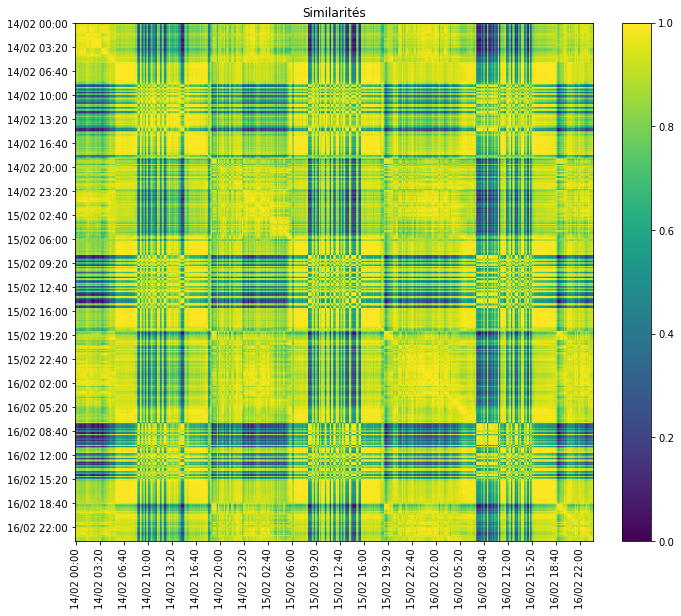

Similarité moyennne :  0.8432643742044716
Similarité minimale :  0.23455130133533825


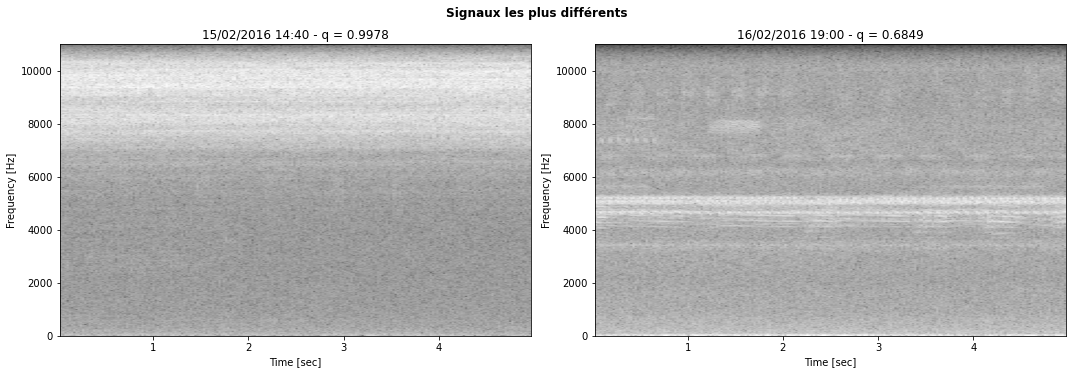

In [9]:
# Calcul de l'ensemble des similarités
psi = getpsi(verbose = False)

similarities = similarity_all(psi)

# Affichage de l'ensemble des similarités
nbSounds = 432
root = './SoundDatabase'
step = 20
dates = getAllDates(root, with_year = False)[::step]

plt.figure(figsize=(8, 8))
ax = plt.axes([0, 0.05, 0.9, 0.9 ])
ax.grid(False)
ax.set_title("Similarités")

im = ax.imshow((similarities - np.min(similarities))/(np.max(similarities) - np.min(similarities)), cmap = 'viridis')

plt.xticks(np.arange(0, nbSounds, step = step), dates, rotation = 90)
plt.yticks(np.arange(0, nbSounds, step = step), dates, rotation = 0)

cax = plt.axes([0.95, 0.05, 0.05,0.9 ])
plt.colorbar(mappable=im, cax=cax)

plt.show()


# Distance moyenne
print("Similarité moyennne : ", np.mean(similarities))


# Distance minimale
ind = np.unravel_index(np.argmin(similarities, axis=None), similarities.shape)
print("Similarité minimale : ", similarities[ind])

# Spectrogramme des 2 signaux les plus différents
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sound, fe = getSoundAtPosition(root, ind[0], 5)
title = "{0} - q = {1:.4f}".format(getDateFromFilename(getFilenameAtPosition(root, ind[0]), with_root=True, root=root), compute_pertinence(sound, fe))
displaySpectrogram(sound, fe, title, ax[0])

sound, fe = getSoundAtPosition(root, ind[1], 5)
title = "{0} - q = {1:.4f}".format(getDateFromFilename(getFilenameAtPosition(root, ind[1]), with_root=True, root=root), compute_pertinence(sound, fe))
displaySpectrogram(sound, fe, title, ax[1])

plt.suptitle("Signaux les plus différents", y = 1.03, fontweight = 'bold')
plt.show()


## Tri par pertinence

In [10]:
def compute_all_pertinence(root, duration = 5):
    
    q = {}

    for root, dirnames, filenames in os.walk(root):
            for f in filenames:
                filename = os.path.join(root, f)
                sound, fe = getSound(filename, duration)
                q[f] = compute_pertinence(sound, fe)
            
    q = dict(sorted(q.items(), key = lambda x: x[1]))

    return q

In [11]:
root = './SoundDatabase'
q = compute_all_pertinence(root)

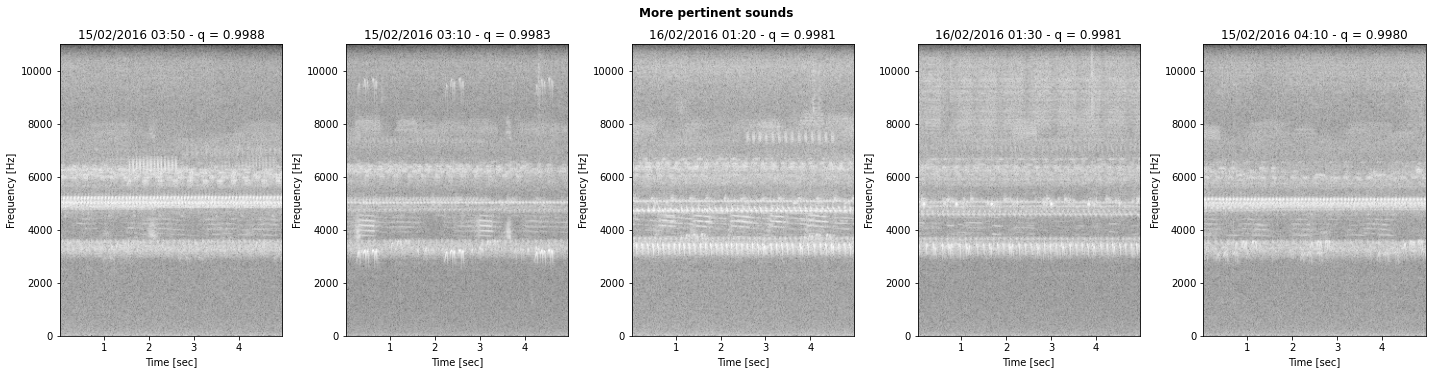

In [12]:
root = './SoundDatabase'
nbSounds = 432
pertinence_files = [list(q.items())[k][0] for k in range(nbSounds)]
pertinence_scores = [list(q.items())[k][1] for k in range(nbSounds)]

nbTop = 5

fig, ax = plt.subplots(1, nbTop, figsize=(20, 5))
for k in range(nbTop):
    sound, fe = getSound(os.path.join(root, pertinence_files[nbSounds - k - 1]), 5)
    title = "{0} - q = {1:.4f}".format(getDateFromFilename(pertinence_files[nbSounds - k - 1]), pertinence_scores[nbSounds - k - 1])
    
    displaySpectrogram(sound, fe, title, ax[k])

plt.suptitle("More pertinent sounds", y = 1.03, fontweight = 'bold')
plt.show()


fig, ax = plt.subplots(1, nbTop, figsize=(20, 5))
for k in range(nbTop):
    sound, fe = getSound(os.path.join(root, pertinence_files[k]), 5)
    title = "{0} - q = {1:.4f}".format(getDateFromFilename(pertinence_files[k]), pertinence_scores[k])
    
    displaySpectrogram(sound, fe, title, ax[k])

plt.suptitle("Least pertinent sounds", y = 1.03, fontweight = 'bold')
plt.show()

In [ ]:
# Calcul de la similarité moyenne entre les signaux de pertinences maximales

root = './SoundDatabase'
nbSounds = 432
nbTop = 5

mean = 0
for i in range(nbTop):
    position1 = getPositionOfFilename(root, pertinence_files[nbSounds - i - 1])
    for j in range(i):
        position2 = getPositionOfFilename(root, pertinence_files[nbSounds - j - 1])
        mean += similarity(position1, position2, psi)
mean /= nbTop * (nbTop - 1) / 2

print(mean)

0.9361934459934584


## TEST

(69,)


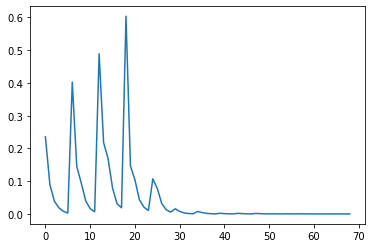

In [ ]:
s, fe = getSound("./SoundDatabase/BRA2S3786_20160214_000000.wav", 1)
J, Q = 8, 3

d = compute_descriptor(s, J, Q)

print(d.shape)
plt.plot(d)
plt.show()

loading psi from persisted file
(432, 69)


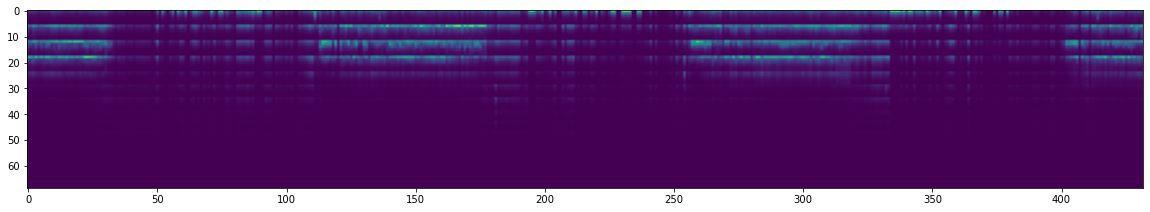

In [ ]:
psi = getpsi()
print(psi.shape)
fig = plt.figure(figsize=(20, 10))
plt.imshow(psi.T)
plt.show()